## Test a repeatable data loading & modeling workflow

In [1]:
from __future__ import division
from dbhelper import pd_query
from modelhelper import cvfolds, plot_waittimes
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [237]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            EXTRACT(MINUTE FROM time - '00:00:00'::time) + 60 * EXTRACT(HOUR FROM time - '00:00:00'::time) minofday
        from crossingdata c
        join datefeatures d on c.date = d.date
        where
            valid=1
            and waittime is not null
            and crossing_id = 1
        order by c.date
        '''

df = pd_query(query)

## Test a Random Forest using year and day of week

In [238]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [239]:
from BorderModel import BorderData, clean_df_subset
dfnew = clean_df_subset(df, ['year', 'dayofweek', 'minofday'])
data = BorderData(dfnew)

In [242]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...40, 735841, 735842, 735843, 735844, 735845, 735846, 735847, 735848, 735849, 735850]]], dtype=object),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

OOB:  0.509661335764
Accuracy:  0.478096898821
R^2:  0.143717723283


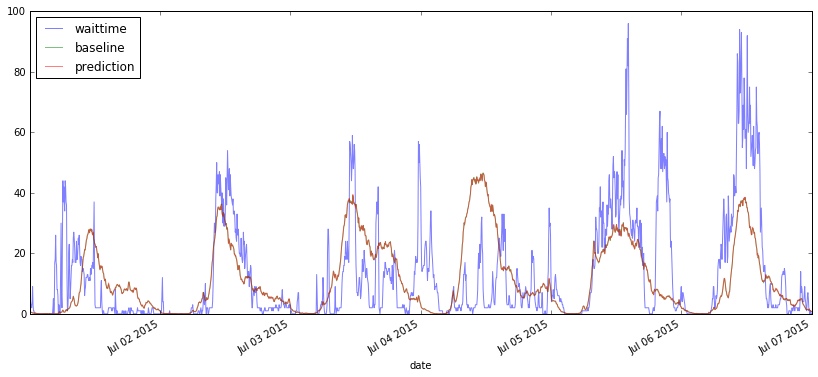

In [243]:
print "OOB: ", grid.best_estimator_.oob_score_
print "Accuracy: ", grid.best_score_
pdf = data.prediction(grid.best_estimator_)
print 'R^2: ', r2_score(pdf.waittime, pdf.prediction)
data.plot(grid, '7/1/15', '7/7/15');

## Matches average by day of week!!!

## Run with 1 hour samples to expedite testing

In [204]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            EXTRACT(MINUTE FROM time - '00:00:00'::time) + 60 * EXTRACT(HOUR FROM time - '00:00:00'::time) minofday
        from crossingdata c
        join datefeatures d on c.date = d.date
        where
            valid=1
            and waittime is not null
            and crossing_id = 1
            and EXTRACT(MINUTE FROM time - '00:00:00'::time) = 0
        order by c.date
        '''

df = pd_query(query)

In [233]:
from BorderModel import BorderData, clean_df_subset
dfnew = clean_df_subset(df, ['year', 'dayofweek', 'minofday'])
data = BorderData(dfnew)

In [229]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)

GridSearchCV(cv=array([[ [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 7...61254, 61255, 61256, 61257, 61258, 61259, 61260, 61261, 61262, 61263, 61264, 61265]]], dtype=object),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

OOB:  0.505902694836
Accuracy:  0.469261872192
R^2:  0.138278954811


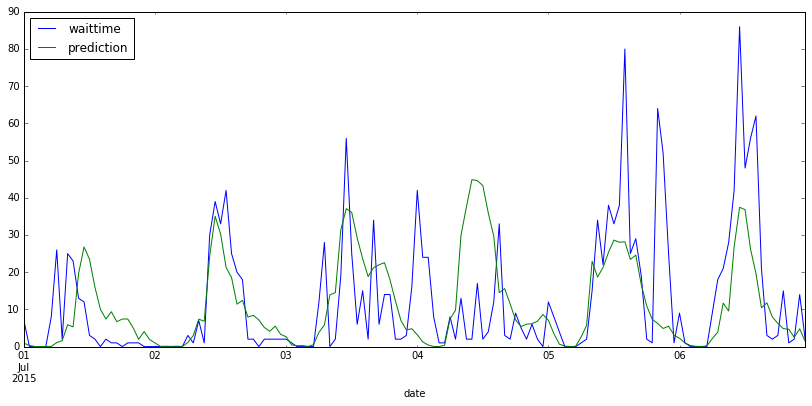

In [230]:
print "OOB: ", grid.best_estimator_.oob_score_
print "Accuracy: ", grid.best_score_
pdf = data.prediction(grid.best_estimator_)
print 'R^2: ', r2_score(pdf.waittime, pdf.prediction)
plot_waittimes(pdf, 'prediction', '7/1/15', '7/7/15')

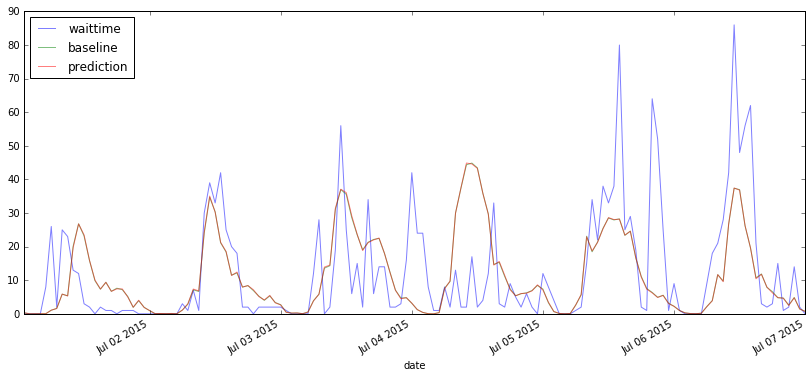

In [236]:
from BorderModel import BorderData, clean_df_subset
data.plot(grid, '7/1/15', '7/7/15');